# Sensitivity analysis

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [29]:
# For operating system interaction
import re

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Read the path to save output files
dropbox = open('../../doc/induction_paper/graphicspath.tex')
output = dropbox.read()
output = re.sub('\\graphicspath{{', '', output)
output = output[1::]
output = re.sub('}}\n', '', output)

# Variability  in fold-change as parameter change.

An interesting observation during our analysis was the fact that as the repressor binding energy $\Delta\varepsilon_{RA}$ decreases (i.e. the repressor binds more strongly to the binding site) the width of the fold-change credible region gets wider.

In this notebook we will explore the origin of this observation by performing a *sensitivity analysis* where we analyze how much the fold-change changes as we vary the value of the dissociation constants for different binding energies and repressor copy numbers.

## The model
Recall that the fold-change equation is given by
$$
\text{fold-change} = \left( 1 + \frac{\left( 1 + \frac{c}{K_A} \right)^2}{\left( 1 + \frac{c}{K_A} \right)^2 + e^{-\beta \Delta\varepsilon_{AI}}\left( 1 + \frac{c}{K_I} \right)^2} \frac{R}{N_{NS}}e^{-\beta\Delta\varepsilon_{RA}} \right)^{-1},
\tag{1}
$$
where $\beta \equiv \frac{1}{k_BT}, $ $c$ is the inducer concentration, $K_A$ and $K_I$ are the dissociation constants of the inducer binding to the repressor in the active and inactive state, respectively, $\Delta\varepsilon_{AI}$ is the energy difference between the active and inactive state conformations, $R$ is the repressor copy number, $N_{NS}$ is the number of non-specific binding sites where the repressor can bind, and $\Delta\varepsilon_{RA}$ is the binding energy of the repressor to the DNA.

To show why the credible regions scale with the repressor copy number and the binding energy we will will analyze the behavior of the change in fold-change as the dissociation constants $K_A$ and $K_I$ are varied. This change is defined
$$
\Delta \text{fold-change}_{K_A} = \text{fold-change}(K_A, K_I) - \text{fold-change}(K_A + \Delta K_A, K_I)
\tag{2}
$$
where $\Delta K_A$ refers to a deviation from the best fit parameter.

In the main text, as the inducer concentration increases, so does the width of the credible regions. Because of that here we explore the limit where $c \rightarrow \infty$. In that limit the fold-change is given by
$$
\lim_{c\rightarrow \infty} \text{fold-change} = \left( 1 + \frac{1}{1 + e^{-\beta\Delta\varepsilon_{AI}} \left( \frac{K_A}{K_I} \right)^2}\frac{R}{N_{NS}}  e^{-\beta\Delta\varepsilon_{RA}}\right)^{-1}
\tag{3}
$$
Let's now define a function to evaluate this equation.

In [8]:
def fold_change_oo(Ka, Ki, R, era, eai=4.5, Nns=4.6E6):
    '''
    computes the gene expression fold change for a simple repression architecture
    in the limit where the inducer concentration goes to infinity
    Parameters
    ----------
    Ka, Ki : float.
        Dissociation constants of the ligand to the active and inactive state
        of the repressor respectively.
    R : float.
        Mean repressor copy number per cell
    era : float.
        Repressor-DNA binding energy
    eai : float.
        Energy difference between active and inactive state of repressor
    Nns : float.
        Number of non-specific binding sites.
    Returns
    -------
    fold-change
    '''
    return (1 + 1 / (1 + np.exp(-eai) * (Ka / Ki)**2) * R / Nns * np.exp(-era))**-1

Let us now define the numerical values for all the needed parameters

In [9]:
era_num = np.array([-15.3, -13.9, -9.7]) # kBT
Ka_num = 139.96 # µM
Ki_num = 0.54 # µM

Let's now plot the change in fold-change as $K_A$ and $K_I$ vary for different energies and repressor copy numbers. 

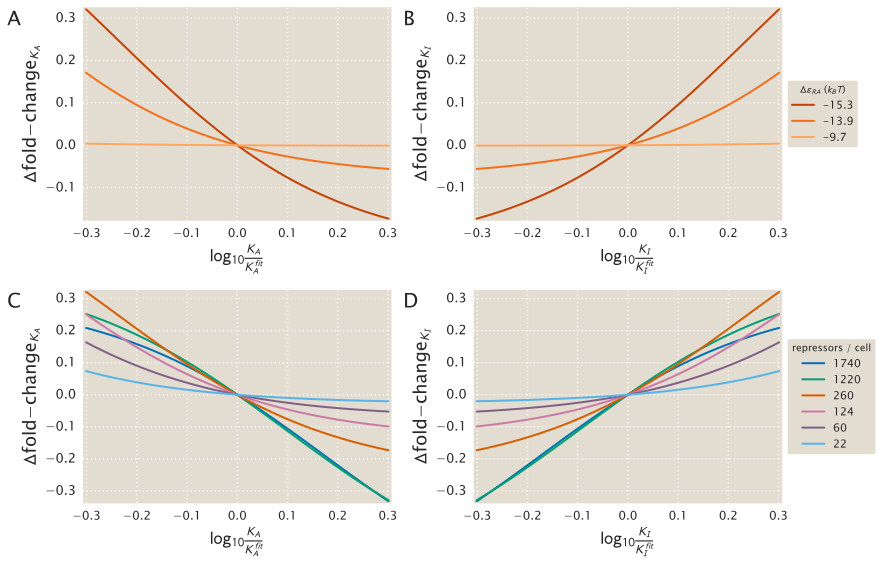

In [45]:
# Factor by which the Ka and Ki are varied
factor = 2

Ka_array = np.logspace(np.log10(Ka_num / factor), 
                       np.log10(Ka_num * factor), 100)
Ki_array = np.logspace(np.log10(Ki_num / factor), 
                       np.log10(Ki_num * factor), 100)


# Initialize plot
fig, ax = plt.subplots(2, 2, figsize=(11, 8))

ax = ax.ravel()

#============================================================================== 
# Fixed R, variable ∆e_RA
#============================================================================== 
# Loopt through binding energies
colors = sns.color_palette('Oranges', n_colors=4)[::-1]
rep = 260 # repressors per cell
for i, eRA in  enumerate(era_num):
    # compute the ∆fold-change_Ka
    delta_fc = fold_change_oo(Ka_num, Ki_num, rep, eRA) -\
               fold_change_oo(Ka_array, Ki_num, rep, eRA)
    
    ax[0].plot(np.log10(Ka_array / Ka_num), delta_fc, 
               label=r'{:.1f}'.format(eRA), color=colors[i])
    
    # compute the ∆fold-change_KI
    delta_fc = fold_change_oo(Ka_num, Ki_num, rep, eRA) -\
               fold_change_oo(Ka_num, Ki_array, rep, eRA)
    
    ax[1].plot(np.log10(Ki_array / Ki_num), delta_fc, 
               label=r'{:.1f}'.format(eRA), color=colors[i])
    
# Format Ka plot
ax[0].set_xlabel(r'$\log_{10} \frac{K_A}{K_A^{fit}}$')
ax[0].set_ylabel(r'$\Delta$fold-change$_{K_A}$')
ax[0].margins(0.01)

# Format Ki plot
ax[1].set_xlabel(r'$\log_{10} \frac{K_I}{K_I^{fit}}$')
ax[1].set_ylabel(r'$\Delta$fold-change$_{K_I}$')
ax[1].margins(0.01)
ax[1].legend(loc='center left', title=r'$\Delta\varepsilon_{RA}$ ($k_BT$)', 
             ncol=1, fontsize=11, bbox_to_anchor=(1,0.5))

#============================================================================== 
# Fixed R, variable ∆e_RA
#============================================================================== 
# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

repressors = [22, 60, 124, 260, 1220, 1740][::-1]
eRA = -15.3
for i, rep in  enumerate(repressors):
# compute the ∆fold-change_Ka
    delta_fc = fold_change_oo(Ka_num, Ki_num, rep, eRA) -\
               fold_change_oo(Ka_array, Ki_num, rep, eRA)
    
    ax[2].plot(np.log10(Ka_array / Ka_num), delta_fc, 
               label=str(rep), color=colors[i])
    
    # compute the ∆fold-change_KI
    delta_fc = fold_change_oo(Ka_num, Ki_num, rep, eRA) -\
               fold_change_oo(Ka_num, Ki_array, rep, eRA)
    
    ax[3].plot(np.log10(Ki_array / Ki_num), delta_fc, 
               label=str(rep), color=colors[i])
    
# Format Ka plot
ax[2].set_xlabel(r'$\log_{10} \frac{K_A}{K_A^{fit}}$')
ax[2].set_ylabel(r'$\Delta$fold-change$_{K_A}$')
ax[2].margins(0.01)

# # Format Ki plot
ax[3].set_xlabel(r'$\log_{10} \frac{K_I}{K_I^{fit}}$')
ax[3].set_ylabel(r'$\Delta$fold-change$_{K_I}$')
ax[3].margins(0.01)
ax[3].legend(loc='center left', title=r'repressors / cell', ncol=1, fontsize=11,
             bbox_to_anchor=(1,0.5))


# Label plot
plt.figtext(0.0, .95, 'A', fontsize=20)
plt.figtext(0.50, .95, 'B', fontsize=20)
plt.figtext(0.0, .46, 'C', fontsize=20)
plt.figtext(0.50, .46, 'D', fontsize=20)

plt.tight_layout()
plt.savefig(output + 'fig_sensitivity_analysis.pdf',
           bbox_inches='tight')

We can see from these plots that the variability in fold-change as the value of the dissociation constants changes is strongly dependent on the repressor binding energy as well as on the repressor copy number. The stronger the repressor binds to the promoter or the more repressors per cel, the bigger the change in fold-change as the values of $K_A$ and $K_I$ change.

This explains the trend in the variability in the credible region width that we observe in the main text.